In [35]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
gamma = 0.8
# wealth level
eps = 0.00001
k_low = 0.01
k_high = 10
# grid size 
grid = 100
ks = np.linspace(k_low, k_high**(0.5),grid)**2

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [36]:
# depreciation
delta = 0.5

Vs = np.zeros(grid)
Cs = np.zeros(grid)
Vs_new = np.copy(Vs)+1
# Value iteration
for j in range(1000):
    if j % 100 == 0:
        print(j)
    if max(abs(Vs_new - Vs)) < 0.01:
        print("converge! ")
        break
    else:
        Vs = np.copy(Vs_new)
    for i in range(len(ks)):
        k = ks[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((1-delta)*k + (k**gamma - c), ks, Vs)))
        bounds = [(0, k**gamma)]
        res = minimize(obj, 0.01, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs_new[i] = -res.fun

0
100
converge! 


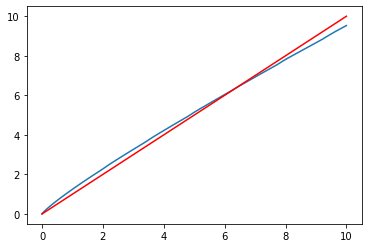

In [37]:
# plot (k vs k_prime)
plt.plot(ks, (1-delta)*ks + (ks**gamma - Cs))
plt.plot([0,k_high],[0,k_high] , "r")

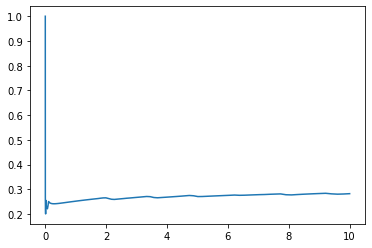

In [38]:
plt.plot(ks, Cs/(ks**gamma))

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ Beta($\alpha$, $\beta$)


Assume the initial value $a_1 = 0$, $b_1 = 0$, $c_1 = 0$, $d_1 = 0$, $a_2 = 0$, $b_2 = 0$, $c_2 = 0$, $d_2 = 0$:
$$\alpha = log(1+ e^{a_1 x^3 + b_1 x^2 + c_1 x + d_1}) + 1 $$
$$\beta = log(1+ e^{a_2 x^3 + b_2 x^2 + c_2 x + d_2}) + 1 $$


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [68]:
T = 100
def poly(the, w):
    value = the[0]*(w**3) + the[1]*(w**2) +the[2]*w + the[3]
    if isscalar(value):
        return max(min(value, 2**32),0)
    else:
        np.clip(value, 0, 2**32, out=value)
        return value

# simulation step T = 100
def a(theta, w):
    value = np.log(1+np.exp(poly(theta[:4],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value

def b(theta, w):
    value = np.log(1+np.exp(poly(theta[4:],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value


def simSinglePath(theta):
    kPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    k = np.random.choice(ks)
    for t in range(T):
        n = np.random.beta(a(theta, k), b(theta, k))
        n = max(min(n,1-eps),eps)
        c = n*(k**gamma)
        kPath[t] = k
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        k = (1-delta)*k + (k**gamma-c)
    return kPath, aPath, rPath

def gradientV(theta, D = 10000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            togoR = np.cumsum(rp[::-1])[::-1]
            newGrad[0] = np.dot(np.log(ap)*(wp**3)/(1+np.exp(-poly(theta[:4],wp))), togoR)
            newGrad[1] = np.dot(np.log(ap)*(wp**2)/(1+np.exp(-poly(theta[:4],wp))), togoR)
            newGrad[2] = np.dot(np.log(ap)*(wp)/(1+np.exp(-poly(theta[:4],wp))), togoR)
            newGrad[3] = np.dot(np.log(ap)*(1)/(1+np.exp(-poly(theta[:4],wp))), togoR)            
            
            newGrad[4] = np.dot(np.log(1-ap)*(wp**3)/(1+np.exp(-poly(theta[4:],wp))), togoR)
            newGrad[5] = np.dot(np.log(1-ap)*(wp**2)/(1+np.exp(-poly(theta[4:],wp))), togoR)
            newGrad[6] = np.dot(np.log(1-ap)*(wp)/(1+np.exp(-poly(theta[4:],wp))), togoR)
            newGrad[7] = np.dot(np.log(1-ap)*(1)/(1+np.exp(-poly(theta[4:],wp))), togoR)
                  
            grad += newGrad
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ks, Cs, 'b')
    plt.plot(ks, a(theta,ks)/(a(theta,ks) + b(theta,ks))*(ks**gamma), 'r')

0
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


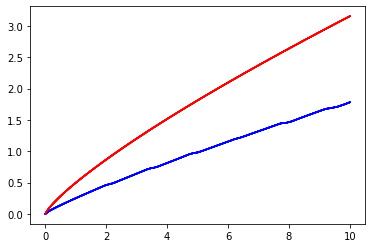

In [69]:
# initial theta 
N = 10
theta = [0.5]*8
# gradient ascend step size 
alpha = 0.001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%10 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)

In [70]:
def V(theta,w):
    value = 0
    D = 1000
    for d in range(D):
        _, _, rp = simSinglePath(theta)
        value += np.sum(rp)
    value /= D
    return value

In [71]:
V(THETA[:,0], 5)

-13.369404587004551

In [73]:
V(THETA[:,9], 5)

-13.009274271364507

approximate theta:  [ 3.30142149e-06 -7.16824121e-04  1.68536248e-01  1.12765628e-01]


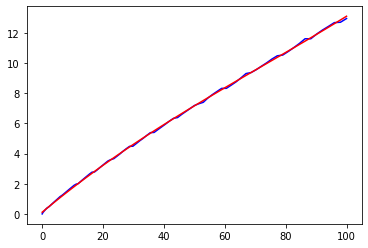

In [6]:
import scipy.optimize as optimization
def func(x, a, b, c, d):
    return a * (x**3) + b*(x**2) + c*(x) + d

theta, cov = optimization.curve_fit(func, ks, Cs)

def fun(x, theta):
    a,b,c,d = theta
    return func(x,a,b,c,d)
plt.plot(ks, Cs, 'b')
plt.plot(ks, fun(ks,theta), 'r')

print("approximate theta: ", theta)

In [9]:
T = 100
sigma = 1

def mu(x, theta):
    return theta[0] * (x**3) + theta[1]*(x**2) + theta[2]*(x) + theta[3]


def simSinglePath(theta):
    kPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    k = np.random.choice(ks)
    for t in range(T):
        c = np.random.normal(mu(k, theta), sigma)
        c = max(min(c,k**gamma),eps)
        if k**gamma < c:
            c = k**gamma/2
        kPath[t] = k
        aPath[t] = c
        rPath[t] = u(c)*(beta**t)
        k = (1-delta)*k + (k**gamma-c)
    return kPath, aPath, rPath

def gradientV(theta, D = 1000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            togoR = np.cumsum(rp[::-1])[::-1]
            newGrad[0] = np.dot((ap-mu(wp,theta))*(wp**3), togoR)
            newGrad[1] = np.dot((ap-mu(wp,theta))*(wp**2), togoR)
            newGrad[2] = np.dot((ap-mu(wp,theta))*(wp), togoR)
            newGrad[3] = np.dot((ap-mu(wp,theta))*1, togoR)
            grad += newGrad
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ks, Cs, 'b')
    plt.plot(ks, mu(ks,theta), 'r')

0
[0, 0, 0, 0]
1
[-3.68714322e+00 -8.36146332e-02 -2.32705178e-03 -8.41832651e-05]
2
[-1.52301635e+07 -2.29689627e+05 -3.92551688e+03 -7.79017416e+01]
3
[-7.15052912e+13 -1.05156236e+12 -1.74466378e+10 -3.36267948e+08]
4
[-3.36965291e+20 -4.93800566e+18 -8.16788860e+16 -1.57156613e+15]
5
[-1.66450426e+27 -2.41562231e+25 -3.96814003e+23 -7.60909833e+21]


KeyboardInterrupt: 

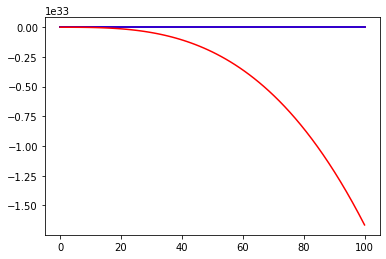

In [12]:
# initial theta 
N = 10
theta = [0] * 4
# gradient ascend step size 
alpha = 0.0000001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%1 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)

approximate theta:  [ 3.06163233e+01  6.30012338e-03  1.21955988e+00 -5.91808413e+00]


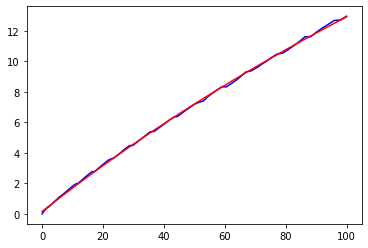

In [13]:
def func(x, a, b, c, d):
    return a * np.log(b*x+c) + d

theta, cov = optimization.curve_fit(func, ks, Cs)

def fun(x, theta):
    a,b,c,d = theta
    return func(x,a,b,c,d)
plt.plot(ks, Cs, 'b')
plt.plot(ks, fun(ks,theta), 'r')

print("approximate theta: ", theta)

In [17]:
T = 100
sigma = 0.1

def mu(w, theta):
    a,b,c,d = theta
    return  a * np.log(b*w+c) + d

def simSinglePath(theta):
    kPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    k = np.random.choice(ks)
    for t in range(T):
        c = np.random.normal(mu(k, theta), sigma)
        c = max(min(c,k**gamma),eps)
        if k**gamma < c:
            c = k**gamma/2
        kPath[t] = k
        aPath[t] = c
        rPath[t] = u(c)*(beta**t)
        k = (1-delta)*k + (k**gamma-c)
    return kPath, aPath, rPath

def gradientV(theta, D = 10000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        w = np.random.uniform(k_low, k_high)
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            togoR = np.cumsum(rp[::-1])[::-1]
            newGrad[0] = np.dot((ap-mu(wp,theta))*np.log(theta[1]*wp+theta[2]), togoR)
            newGrad[1] = np.dot((ap-mu(wp,theta))*(theta[0]*wp)/(theta[1]*wp+theta[2]), togoR)
            newGrad[2] = np.dot((ap-mu(wp,theta))*theta[0]/(theta[1]*wp+theta[2]), togoR)
            newGrad[3] = np.dot((ap-mu(wp,theta))*1, togoR)            
            grad += newGrad
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ks, Cs, 'b')
    plt.plot(ks, mu(ks,theta), 'r')

0
[0.1, 0.1, 0.1, 0.1]
1
[0.11155471 0.09859976 0.0962106  0.09481036]
2
[0.12796093 0.09595021 0.0898742  0.08700367]
3
[0.14907268 0.09083789 0.07999695 0.07623289]
4
[0.18108849 0.07966018 0.06157821 0.05953766]
5
[0.24702481 0.0423269  0.00954374 0.02542083]
6
[ 0.64348725 -0.80769645 -0.95187008 -0.15737187]


KeyboardInterrupt: 

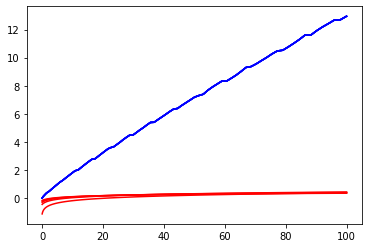

In [27]:
# initial theta 
N = 10
theta = [0.1] * 4
# gradient ascend step size 
alpha = 0.001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%1 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)

In [ ]:
def V(theta,w):
    value = 0
    D = 1000
    for d in range(D):
        _, _, rp = simSinglePath(theta)
        value += np.sum(rp)
    value /= D
    return value

In [ ]:
V(THETA[:,0],5)

In [ ]:
V(THETA[:,9],5)